In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the dataset
data = pd.read_csv('preprocessed_dataset.csv')

# Reduce dataset size
data_subset = 6000 # Adjust this number as needed
texts = data['lemmatized_title'].tolist()[:data_subset]
labels = data['real'].tolist()[:data_subset]

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

# Tokenization and padding
max_vocab_size = 10000  # Reduce vocabulary size
max_length = 50  # Reduce sequence length

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post')

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with reduced epochs for faster execution
history = model.fit(train_padded, np.array(train_labels), epochs=3, batch_size=32, validation_split=0.1)

# Evaluate the model
val_predictions = (model.predict(val_padded) > 0.5).astype("int32")

# Generate the classification report
report = classification_report(val_labels, val_predictions, target_names=['Fake', 'Real'])
print(report)


Epoch 1/3
152/152 [==============================] - 6s 33ms/step - loss: 0.5266 - accuracy: 0.7648 - val_loss: 0.4006 - val_accuracy: 0.8370
Epoch 2/3
152/152 [==============================] - 5s 35ms/step - loss: 0.3010 - accuracy: 0.8741 - val_loss: 0.3964 - val_accuracy: 0.8315
Epoch 3/3
19/19 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

        Fake       0.65      0.51      0.57       170
        Real       0.82      0.89      0.85       430

    accuracy                           0.78       600
   macro avg       0.73      0.70      0.71       600
weighted avg       0.77      0.78      0.77       600



In [6]:
from kerastuner.tuners import RandomSearch
import tensorflow as tf

# Define a function for model building
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length))

    # Tune the number of filters and kernel size for Conv1D layers
    model.add(tf.keras.layers.Conv1D(filters=hp.Int('conv1d_filters', min_value=32, max_value=256, step=32),
                                     kernel_size=hp.Choice('conv1d_kernel', values=[3, 5, 7]),
                                     activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())

    # Tune the number of units in the Dense layers
    model.add(tf.keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust as needed
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='cnn_tuning'
)

# Perform hyperparameter search
tuner.search(train_padded, np.array(train_labels),
             epochs=3,
             validation_data=(val_padded, np.array(val_labels)),
             batch_size=32)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps}")


Trial 10 Complete [00h 00m 16s]
val_accuracy: 0.79666668176651

Best val_accuracy So Far: 0.8199999928474426
Total elapsed time: 00h 04m 44s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7b7ec52f1780>


In [16]:
#getting classification report for the best model

import numpy as np
# Train the best model with more epochs for improved accuracy
best_model.fit(train_padded, np.array(train_labels), epochs=10, batch_size=32, validation_data=(val_padded, np.array(val_labels)))

# Generate predictions on the test set
test_predictions = (best_model.predict(test_padded) > 0.5).astype("int32")

# Generate the classification report
report = classification_report(test_labels, test_predictions, target_names=['Fake', 'Real'])
print(report)


Epoch 1/10
169/169 [==============================] - 10s 50ms/step - loss: 0.2543 - accuracy: 0.9017 - val_loss: 0.4766 - val_accuracy: 0.8000
Epoch 2/10
169/169 [==============================] - 9s 55ms/step - loss: 0.0837 - accuracy: 0.9711 - val_loss: 0.6610 - val_accuracy: 0.7933
Epoch 3/10
169/169 [==============================] - 8s 45ms/step - loss: 0.0346 - accuracy: 0.9889 - val_loss: 0.8013 - val_accuracy: 0.7967
Epoch 4/10
169/169 [==============================] - 9s 54ms/step - loss: 0.0164 - accuracy: 0.9956 - val_loss: 0.9148 - val_accuracy: 0.7833
Epoch 5/10
169/169 [==============================] - 8s 48ms/step - loss: 0.0136 - accuracy: 0.9963 - val_loss: 0.9081 - val_accuracy: 0.7933
Epoch 6/10
169/169 [==============================] - 9s 52ms/step - loss: 0.0146 - accuracy: 0.9961 - val_loss: 0.9423 - val_accuracy: 0.7917
Epoch 7/10
169/169 [==============================] - 9s 54ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 1.0450 - val_accuracy: 0.788

313/313 [==============================] - 3s 10ms/step


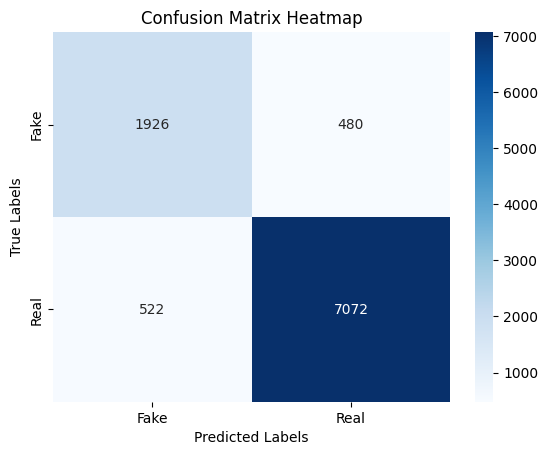

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences

# Assuming 'test_texts' contains the raw text data for the test set
test_texts = data['lemmatized_title'].tolist()[:data_subset]
test_labels = data['real'].tolist()[:data_subset]

# Convert any potential float values to strings
test_texts = [str(text) for text in test_texts]  # Convert floats to strings

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post') # Preprocess test data

# Generate predictions on the test set
test_predictions = (best_model.predict(test_padded) > 0.5).astype("int32")

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Create a heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()